In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 7.8 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import dataProcess

from datetime import datetime
import matplotlib.pyplot as plt
import optuna
import numpy as np

In [3]:
hourly = 'weatherstats_toronto_hourly.csv'
daily = 'weatherstats_toronto_daily.csv'
start = datetime(2014, 4, 16).date()
end = datetime(2024, 4, 10).date()
data = dataProcess.generateDataNoLoader(hourly, daily, start, end)
train_data = data['train']
val_data = data['validation']
test_data = data['test']

In [4]:
def create_dataloaders(train_data, val_data, test_data, batch_size=2048):
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
  return train_loader, val_loader, test_loader

In [17]:
class WeatherPredictorTransformer(nn.Module):
  def __init__(self, input_size, d_model, nhead, num_encoder_layers, output_size, dropout_rate, hidden_size):
    super(WeatherPredictorTransformer, self).__init__()
    self.embedding = nn.Linear(input_size, d_model)
    self.positional_encoding = nn.Parameter(self.create_sinusoidal_positional_encoding(24, d_model), requires_grad=False)
    self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout_rate)
    self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)

    self.norm1 = nn.LayerNorm(d_model)
    self.linear1 = nn.Linear(d_model, hidden_size)
    self.norm2 = nn.LayerNorm(hidden_size)
    self.linear2 = nn.Linear(hidden_size, d_model)
    self.norm3 = nn.LayerNorm(d_model)

    self.output_linear = nn.Linear(d_model, output_size)

  def forward(self, x):
    x = self.embedding(x)
    x += self.positional_encoding[:x.size(1), :]
    x = x.permute(1, 0, 2)
    encoder_output = self.transformer_encoder(x)

    x = self.norm1(encoder_output[-1])
    x = F.relu(self.linear1(x))
    x = self.norm2(x)
    x = F.relu(self.linear2(x))
    x = self.norm3(x)

    prediction = self.output_linear(x)
    return prediction

  @staticmethod
  def create_sinusoidal_positional_encoding(length, d_model):
    PE = torch.zeros(length, d_model)
    position = torch.arange(0, length, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))
    PE[:, 0::2] = torch.sin(position * div_term)
    PE[:, 1::2] = torch.cos(position * div_term)
    return PE


In [21]:
def train_model(trial, model, num_epochs, train_loader, val_loader, device):
  criterion = nn.MSELoss()
  learning_rate = trial.suggest_loguniform('lr', 1e-6, 1e-3)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      inputs, targets = inputs.float(), targets.float()
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      total_train_loss += loss.item()

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
      for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets = inputs.float(), targets.float()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_val_loss += loss.item()

  avg_val_loss = total_val_loss / len(val_loader)
  return avg_val_loss

In [19]:
def objective(trial):
  input_size = 13
  hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])
  d_model = trial.suggest_categorical('d_model', [64, 128, 256])
  nhead = trial.suggest_categorical('nhead', [4, 8])
  num_encoder_layers = trial.suggest_int('num_encoder_layers', 1, 4)
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.3)
  output_size = 1

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = WeatherPredictorTransformer(input_size, d_model, nhead, num_encoder_layers, output_size, dropout_rate, hidden_size)
  model.to(device)

  train_loader, val_loader, _ = create_dataloaders(train_data, val_data, test_data)

  num_epochs = 50
  return train_model(trial, model, num_epochs, train_loader, val_loader, device)

In [22]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
for key, value in trial.params.items():
  print(f"    {key}: {value}")

[I 2024-04-19 05:15:42,108] A new study created in memory with name: no-name-ef58daad-9d3f-437f-82bd-7d9032f7a9f6
<ipython-input-19-f8e2d1d80c37>:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.3)
<ipython-input-21-8fb950ba11a1>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-6, 1e-3)
[I 2024-04-19 05:15:47,937] Trial 0 finished with value: 130.13304138183594 and parameters: {'hidden_size': 128, 'd_model': 128, 'nhead': 4, 'num_encoder_layers': 3, 'dropout_rate': 0.08892509752214059, 'lr': 2.7938969062789546e-05}. Best is trial 0 with value: 130.13304138183594.
[W 2024-04-19 05

Best trial:
  Value: 116.03826904296875
    hidden_size: 256
    d_model: 256
    nhead: 8
    num_encoder_layers: 2
    dropout_rate: 0.10869047580942337
    lr: 0.0008753099356097883


Epoch [1/50], Training Loss: 188.7489, Validation Loss: 162.9723
Epoch [2/50], Training Loss: 158.5843, Validation Loss: 142.1464
Epoch [3/50], Training Loss: 135.9500, Validation Loss: 133.8383
Epoch [4/50], Training Loss: 129.2900, Validation Loss: 129.4006
Epoch [5/50], Training Loss: 123.0329, Validation Loss: 126.7622
Epoch [6/50], Training Loss: 125.2383, Validation Loss: 125.0357
Epoch [7/50], Training Loss: 128.6355, Validation Loss: 123.5644
Epoch [8/50], Training Loss: 122.8032, Validation Loss: 122.2886
Epoch [9/50], Training Loss: 117.4005, Validation Loss: 121.2276
Epoch [10/50], Training Loss: 112.8932, Validation Loss: 120.3580
Epoch [11/50], Training Loss: 121.1605, Validation Loss: 119.6212
Epoch [12/50], Training Loss: 118.8414, Validation Loss: 118.9968
Epoch [13/50], Training Loss: 119.8411, Validation Loss: 118.5297
Epoch [14/50], Training Loss: 123.3519, Validation Loss: 118.1716
Epoch [15/50], Training Loss: 121.9405, Validation Loss: 117.8679
Epoch [16/50], Trai

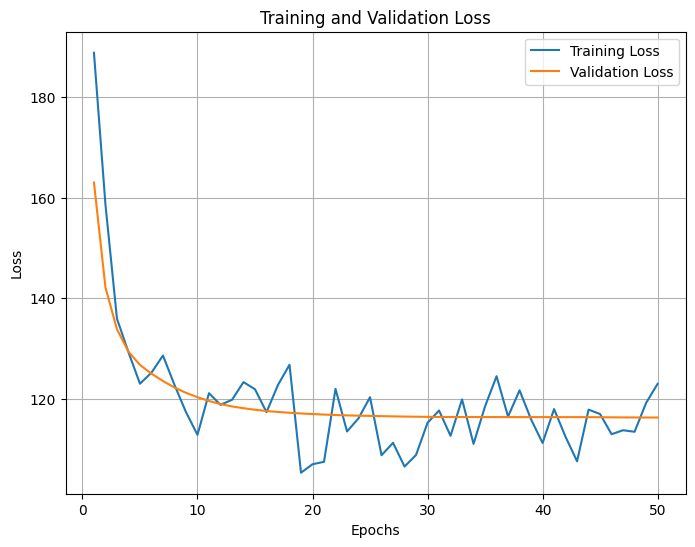

In [28]:
'''
Best trial:
  Value: 116.03826904296875
    hidden_size: 256
    d_model: 256
    nhead: 8
    num_encoder_layers: 2
    dropout_rate: 0.10869047580942337
    lr: 0.00008753099356097883
'''

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

learning_rate = 0.00008753099356097883
num_epochs = 50

input_size = 13
d_model = 256
nhead = 8
num_encoder_layers = 2
dropout_rate = 0.10869047580942337
hidden_size = 256

output_size = 1

model = WeatherPredictorTransformer(input_size, d_model, nhead, num_encoder_layers, output_size, dropout_rate, hidden_size)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

train_loader, val_loader, test_loader = create_dataloaders(train_data, val_data, test_data)

def train_model(model, num_epochs, optimizer, criterion, train_loader, val_loader, device):
  train_losses = []
  val_losses = []

  for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      inputs, targets = inputs.float(), targets.float()
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
      for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets = inputs.float(), targets.float()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

  # Plotting
  plt.figure(figsize=(8, 6))
  plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
  plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
train_model(model, num_epochs, optimizer, criterion, train_loader, val_loader, device)

In [31]:
def evaluate_and_collect_data(model, data_loader, device):
  model.eval()
  total_mae = 0
  count = 0
  predictions = []
  actuals = []

  with torch.no_grad():
    for inputs, targets in data_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      inputs, targets = inputs.float(), targets.float()
      outputs = model(inputs)
      mae = torch.abs(outputs - targets).mean()
      total_mae += mae.item()
      count += 1

      predictions.extend(outputs.view(-1).detach().cpu().numpy())
      actuals.extend(targets.view(-1).detach().cpu().numpy())

  loss = criterion(outputs, targets)
  avg_mae = total_mae / count
  return predictions, actuals, avg_mae, loss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

predictions, actuals, avg_mae, loss = evaluate_and_collect_data(model, test_loader, device)
print(f'Mean Prediction Error: {avg_mae:.4f}')
print(f'Loss: {loss:.4f}')

Mean Prediction Error: 8.3913
Loss: 92.3799


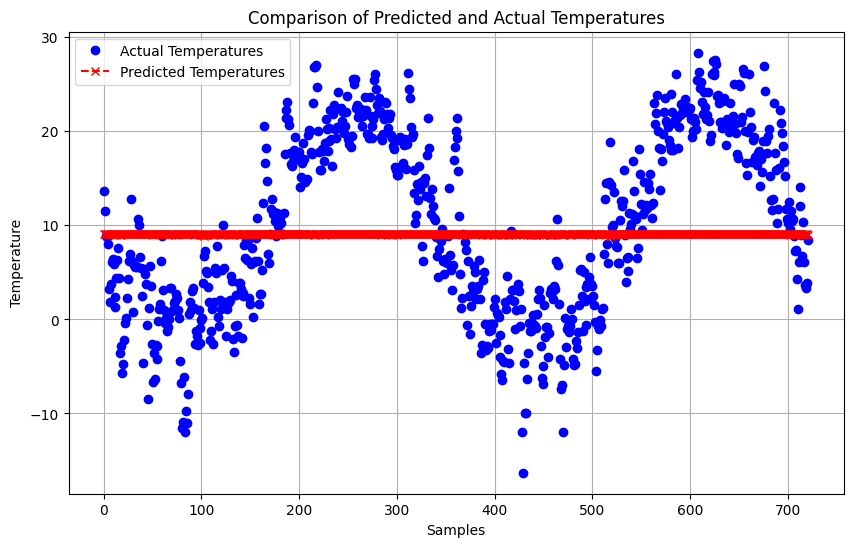

In [32]:
def plot_predictions_vs_actuals(predictions, actuals):
  plt.figure(figsize=(10, 6))
  plt.plot(actuals, label='Actual Temperatures', color='blue', marker='o', linestyle='')
  plt.plot(predictions, label='Predicted Temperatures', color='red', linestyle='--', marker='x')
  plt.title('Comparison of Predicted and Actual Temperatures')
  plt.xlabel('Samples')
  plt.ylabel('Temperature')
  plt.legend()
  plt.grid(True)
  plt.show()

plot_predictions_vs_actuals(predictions, actuals)